# **Failure Cause Classification: Predictive Maintenance of Water Pump Systems**

* **Group 9:** Aktham Almomani
* **Course:** Data Analytics and Internet of Things (AAI-530-04)/ University Of San Diego
* **Semester:** Spring 2025



## **Contents**<a is='Contents'></a>
* [Introduction](#Introduction)
* [Dataset](#Dataset)
* [Setup and preliminaries](#Setup_and_preliminaries)
  * [Import Libraries](#Import_libraries)
  * [Helper functions](#Helper_Functions)
* [Importing the dataset](#Importing_the_dataset)
* [Failure Cause Transformation](#Failure_Cause_transformation)
* [Extracting Time-Based Features](#Extracting_Time_Based_Features)
* [Encoding Failure Causes](#Encoding_Failure_Causes)
* [Correlation](#Correlation)
* [Selecting the features](#Selecting_the_features)
* [Splitting the Data for Training and Testing](#Splitting_Data)
* [Scaling the Features](#Scaling_Features)
* [Training Machine Learning Model](#modeling)
* [Model Evaluation](#Model_Evaluation)
* [Features Importance](#Features_Importance)
* [Saving the prediction dataset](#Saving_prediction)

## **Introduction**<a id='Introduction'></a>
[Contents](#Contents)

Before training our model, we need to prepare the dataset to ensure we capture useful patterns in the data. Here's the plan:

* Extract Time-Based Features
Failures may have patterns based on time of day, month, or hour, so we'll extract:

 * Day: Some failures could be more frequent on certain days.
 * Month: Seasonal or long-term trends in failures.
 * Hour: Failures could correlate with operational loads (e.g., peak usage hours).
* Select Key Sensors as Features (X)
We'll use our selected key sensors to help classify failures. The following sensors are included:

 * snr_01_motor_phase_current
 * snr_02_motor_shaft_power
 * snr_03_motor_speed
 * snr_04_pump_impeller_speed
 * snr_05_pump_casing_vibration
 * snr_06_pump_discharge_pressure
 * snr_07_pump_lube_oil_supply_temp
 * snr_08_motor_casing_vibration
 * snr_09_motor_phase_voltage
* Define the Target Variable (y)
Our target variable is failure_cause, which classifiesfailure causes.



## **Dataset**<a id='Dataset'></a>
[Contents](#Contents)

The dataset we'll be using is called "Pump Sensor Data" and is available on [Kaggle](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/data). This dataset provides real-world IoT sensor data collected from water pump systems.

**Data Collection**: The data was gathered from sensors installed in water pump systems. These sensors monitor a wide range of parameters such as motor and pump vibrations, frequencies, power usage, and bearing temperatures. The collection process spans over time, capturing changes in system behavior and helping identify operational issues or equipment failures.

**Dataset Overview**:
* Number of Observations: The dataset contains 220,320 entries.
* Number of Variables: There are 55 columns, including 52 numerical variables (sensor readings), one timestamp column, and one categorical column representing machine status

## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [2]:
#Let's import the necessary packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

# let's run below to customize notebook display:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000) # 100 means 100 characters in the col

# format floating-point numbers to 2 decimal places:
pd.set_option('float_format', '{:.4f}'.format)

### **Helper functions**<a id='Helper_Functions'></a>
[Contents](#Contents)

In [3]:
def summarize_df(df):
    """
    Generate a summary DataFrame for an input DataFrame:
      - 'unique_count': No. unique values in each column.
      - 'data_types': Data types of each column.
      - 'missing_counts': No. of missing (NaN) values in each column.
      - 'missing_percentage': Percentage of missing values in each column.
    """
    # No. of unique values for each column:
    unique_counts = df.nunique()
    # Data types of each column:
    data_types = df.dtypes
    # No. of missing (NaN) values in each column:
    missing_counts = df.isnull().sum()
    # Percentage of missing values in each column:
    missing_percentage = 100 * df.isnull().mean()
    # Concatenate the above metrics:
    summary_df = pd.concat([unique_counts, data_types, missing_counts, missing_percentage], axis=1)
    # Rename the columns for better readibility:
    summary_df.columns = ['unique_count', 'data_types', 'missing_counts', 'missing_percentage']
    # Return summary df:
    return summary_df
#-----------------------------------------------------------------------------------------------------------------#
def value_counts_with_percentage(df, column_name):
    # Calculate value counts:
    counts = df[column_name].value_counts(dropna=False)

    # Calculate percentages:
    percentages = df[column_name].value_counts(dropna=False, normalize=True) * 100

    # Combine into a DataFrame and reset index:
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    }).rename_axis(None).reset_index()

    # Rename the first column to match the original column name:
    result.rename(columns={'index': column_name}, inplace=True)

    return result
#-----------------------------------------------------------------------------------------------------------------#
def dynamic_impute(df, threshold=0.1):
    """
    Impute missing values dynamically based on the gap between mean and median.
    """
    # Get sensor columns:
    sensor_columns = [col for col in df.columns if col.startswith('snr')]

    for col in sensor_columns:
        mean_val = df[col].mean()
        median_val = df[col].median()

        # Calculate percentage difference:
        diff = abs(mean_val - median_val) / mean_val

        # Imputation decision:
        if diff <= threshold:
            # Mean and median are close, use the mean:
            df[col] = df[col].fillna(mean_val)
            print(f"Imputed '{col}' using mean (diff = {diff:.2%})")
        elif median_val > mean_val:
            # Median is significantly higher, use the median:
            df[col] = df[col].fillna(median_val)
            print(f"Imputed '{col}' using median because median > mean (diff = {diff:.2%})")
        else:
            # Use median for any other skewed cases:
            df[col] = df[col].fillna(median_val)
            print(f"Imputed '{col}' using median (diff = {diff:.2%})")

    return df


## **Importing the dataset**<a id='Importing_the_dataset'></a>
[Contents](#Contents)

Since I'm using google colab, let's mount the driver:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#First, let's load the clean sensor dataset : Data wrangling and preprocessing output
df = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/sensor_clean_df.csv'
)

In [6]:
#now, let's look at the shape of df:
shape = df.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 220320 
Number of columns: 23


In [7]:
# Here's, let's call again our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,object,0,0.0000
snr_01_motor_phase_current,187145,float64,0,0.0000
snr_02_motor_shaft_power,566,float64,0,0.0000
snr_03_motor_speed,7845,float64,0,0.0000
snr_04_pump_impeller_speed,100422,float64,0,0.0000
snr_05_pump_casing_vibration,152604,float64,0,0.0000
snr_06_pump_discharge_pressure,1109,float64,0,0.0000
snr_07_pump_lube_oil_supply_temp,910,float64,0,0.0000
snr_08_motor_casing_vibration,1254,float64,0,0.0000
snr_09_motor_phase_voltage,148001,float64,0,0.0000


In [8]:
# Now, let's look at the top 5 rows of the df:
df.head()

,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,machine_status,snr_01_motor_phase_current_flag,snr_02_motor_shaft_power_flag,snr_03_motor_speed_flag,snr_04_pump_impeller_speed_flag,snr_05_pump_casing_vibration_flag,snr_06_pump_discharge_pressure_flag,snr_07_pump_lube_oil_supply_temp_flag,snr_08_motor_casing_vibration_flag,snr_09_motor_phase_voltage_flag,failure_category,failure_cause,faulty_sensors
0,2018-04-01 00:00:00,31.1172,15.0535,634.3750,665.3993,2.5653,201.3889,31.5104,2.4654,466.3284,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors
1,2018-04-01 00:01:00,31.1172,15.0535,634.3750,665.3993,2.5653,201.3889,31.5104,2.4654,466.3284,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors
2,2018-04-01 00:02:00,32.0889,15.0101,638.8889,666.2234,2.5001,203.7037,31.2500,2.4447,459.6364,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors
3,2018-04-01 00:03:00,31.6722,15.0825,628.1250,666.0114,2.5095,203.1250,31.5104,2.4605,460.8858,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors
4,2018-04-01 00:04:00,31.9520,15.0825,636.4583,663.2111,2.6048,201.3889,31.5104,2.4457,468.2206,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors


## **Failure Cause Transformation**<a id='Failure_Cause_transformation'></a>
[Contents](#Contents)

In here, I take failure_cause, my target variable, and reduce its 18 unique categories down to just 6 broader classes. This transformation helps streamline the classification process, making it easier to train models, interpret results, and identify key failure trends without unnecessary complexity. By grouping similar failure types together, I ensure the dataset remains informative while improving model performance and analysis efficiency.


In [9]:
# Filter for abnormal machine status only
df_failure = df[df["failure_cause"] != "no_failure"].copy().reset_index(drop=True)

In [10]:
# Alright, let's fix up 'timestamp' to be datetime:
df_failure['timestamp']=pd.to_datetime(df_failure['timestamp'])

# Define the date range for the subset
start_date = "2018-04-26"
end_date = "2018-05-31"

# Filter the dataset
df_failure = df_failure[(df_failure["timestamp"] >= start_date) & (df_failure["timestamp"] <= end_date)].copy()

In [36]:
#now, let's look at the shape of df_failure:
shape = df_failure.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 10951 
Number of columns: 30


In [11]:
value_counts_with_percentage(df_failure, 'failure_cause')

,failure_cause,Count,Percentage
0,"rotational_issue, vibration_issue, electrical_issue",17088,78.0203
1,"vibration_issue, electrical_issue",1752,7.9993
2,vibration_issue,1006,4.5932
3,"rotational_issue, vibration_issue",860,3.9266
4,rotational_issue,791,3.6115
5,electrical_issue,114,0.5205
6,"vibration_issue, temperature_ssue",77,0.3516
7,temperature_ssue,70,0.3196
8,"rotational_issue, vibration_issue, temperature_ssue, electrical_issue",65,0.2968
9,"vibration_issue, temperature_ssue, electrical_issue",44,0.2009


In [12]:
# Mapping function:
def map_failure_classes(failure):
    if failure == "rotational_issue, vibration_issue, electrical_issue":
        return "rotational_issue, vibration_issue, electrical_issue"
    elif failure == "vibration_issue, electrical_issue":
        return "vibration_issue, electrical_issue"
    elif failure == "vibration_issue":
        return "vibration_issue"
    elif failure == "rotational_issue, vibration_issue":
        return "rotational_issue, vibration_issue"
    elif failure == "rotational_issue":
        return "rotational_issue"
    else:
        return "Others"

# Apply transformation:
df_failure["failure_cause_v1"] = df_failure["failure_cause"].apply(map_failure_classes)
value_counts_with_percentage(df_failure, 'failure_cause_v1')

,failure_cause_v1,Count,Percentage
0,"rotational_issue, vibration_issue, electrical_issue",17088,78.0203
1,"vibration_issue, electrical_issue",1752,7.9993
2,vibration_issue,1006,4.5932
3,"rotational_issue, vibration_issue",860,3.9266
4,rotational_issue,791,3.6115
5,Others,405,1.8491


Alright, that looks better, 6 classes better than 18 classes!!

## **Extracting Time-Based Features**<a id='Extracting_Time_Based_Features'></a>
[Contents](#Contents)

Since this is a time-series problem, we want to capture patterns based on day, month, and hour. This helps our model understand when failures are more likely to happen.

In [13]:
# Extract time-based features:
df_failure["day"] = df_failure["timestamp"].dt.day
df_failure["month"] = df_failure["timestamp"].dt.month
df_failure["hour"] = df_failure["timestamp"].dt.hour

In [14]:
df_failure.head()

,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,machine_status,snr_01_motor_phase_current_flag,snr_02_motor_shaft_power_flag,snr_03_motor_speed_flag,snr_04_pump_impeller_speed_flag,snr_05_pump_casing_vibration_flag,snr_06_pump_discharge_pressure_flag,snr_07_pump_lube_oil_supply_temp_flag,snr_08_motor_casing_vibration_flag,snr_09_motor_phase_voltage_flag,failure_category,failure_cause,faulty_sensors,failure_cause_v1,day,month,hour
5447,2018-04-28 13:00:00,11.1652,15.0535,617.3611,49.0317,1.7495,209.7801,30.2083,2.4388,383.9602,ABNORMAL,0,0,0,1,0,0,0,0,0,critical_failure,rotational_issue,snr_04_pump_impeller_speed,rotational_issue,28,4,13
5448,2018-04-28 13:01:00,11.1652,15.0535,617.3611,49.0317,1.7495,208.0440,30.2083,2.4388,383.9602,ABNORMAL,0,0,0,1,0,0,0,0,0,critical_failure,rotational_issue,snr_04_pump_impeller_speed,rotational_issue,28,4,13
5449,2018-04-28 13:02:00,10.9377,15.1186,623.8426,54.3729,1.7336,205.4398,30.2083,2.4369,382.7150,ABNORMAL,0,0,0,1,0,0,0,0,0,critical_failure,rotational_issue,snr_04_pump_impeller_speed,rotational_issue,28,4,13
5450,2018-04-28 13:03:00,10.8380,15.0535,639.4676,66.9203,1.7917,202.5463,30.2083,2.4349,389.8215,ABNORMAL,0,0,0,1,0,0,0,0,0,critical_failure,rotational_issue,snr_04_pump_impeller_speed,rotational_issue,28,4,13
5451,2018-04-28 13:04:00,10.8435,15.1186,624.5370,76.3643,1.7481,199.6528,29.9479,2.4388,383.7621,ABNORMAL,0,0,0,1,0,0,0,0,0,critical_failure,rotational_issue,snr_04_pump_impeller_speed,rotational_issue,28,4,13


## **Encoding Failure Causes**<a id='Encoding_Failure_Causes'></a>
[Contents](#Contents)

In here, I convert failure_cause_v1 into numerical labels using a mapping approach to optimize it for machine learning models. By reducing 18 failure categories into 4 distinct classes, this transformation improves model performance, enhances interpretability, and ensures efficient processing. This step is essential for handling categorical data in classification tasks.

In [16]:
value_counts_with_percentage(df_failure, 'failure_cause_v1')

,failure_cause_v1,Count,Percentage
0,"rotational_issue, vibration_issue, electrical_issue",17088,78.0203
1,"vibration_issue, electrical_issue",1752,7.9993
2,vibration_issue,1006,4.5932
3,"rotational_issue, vibration_issue",860,3.9266
4,rotational_issue,791,3.6115
5,Others,405,1.8491


In [17]:
# First, let's Convert failure_cause_v1 to binary values:
df_failure["failure_cause_v2"] = df_failure["failure_cause_v1"].map({
    "rotational_issue, vibration_issue, electrical_issue": 0,
    "vibration_issue, electrical_issue": 1,
    "vibration_issue": 2,
    "rotational_issue, vibration_issue": 3,
    "rotational_issue": 4,
    "Others": 5
})

In [18]:
value_counts_with_percentage(df_failure, 'failure_cause_v2')

,failure_cause_v2,Count,Percentage
0,0,17088,78.0203
1,1,1752,7.9993
2,2,1006,4.5932
3,3,860,3.9266
4,4,791,3.6115
5,5,405,1.8491


## **Correlation**<a id='Correlation'></a>
[Contents](#Contents)



In [19]:
corr_df = df_failure[[
    "day", "month", "hour",
     "snr_01_motor_phase_current", "snr_02_motor_shaft_power", "snr_03_motor_speed",
     "snr_04_pump_impeller_speed", "snr_05_pump_casing_vibration", "snr_06_pump_discharge_pressure",
     "snr_07_pump_lube_oil_supply_temp", "snr_08_motor_casing_vibration", "snr_09_motor_phase_voltage", 'failure_cause_v2']]



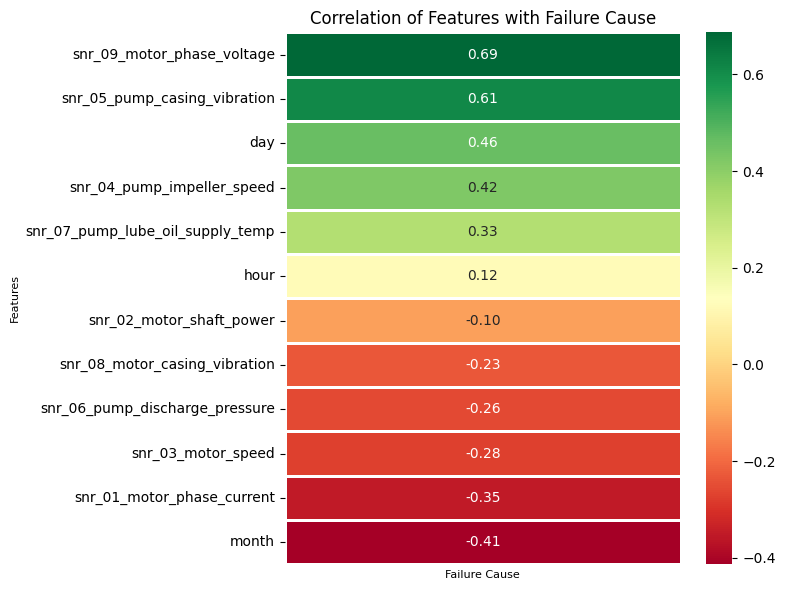

In [20]:
corr = corr_df.corr()
# Extract correlations with the target variable:
correlation_with_target = corr[['failure_cause_v2']].drop(index='failure_cause_v2').sort_values(by='failure_cause_v2', ascending=False)

# Visualize the correlation with the target variable using a heatmap:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_target, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=2)
plt.title('Correlation of Features with Failure Cause', fontsize=12)
plt.xlabel('Failure Cause', fontsize=8)
plt.ylabel('Features', fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.xticks(ticks=[], labels=[], rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

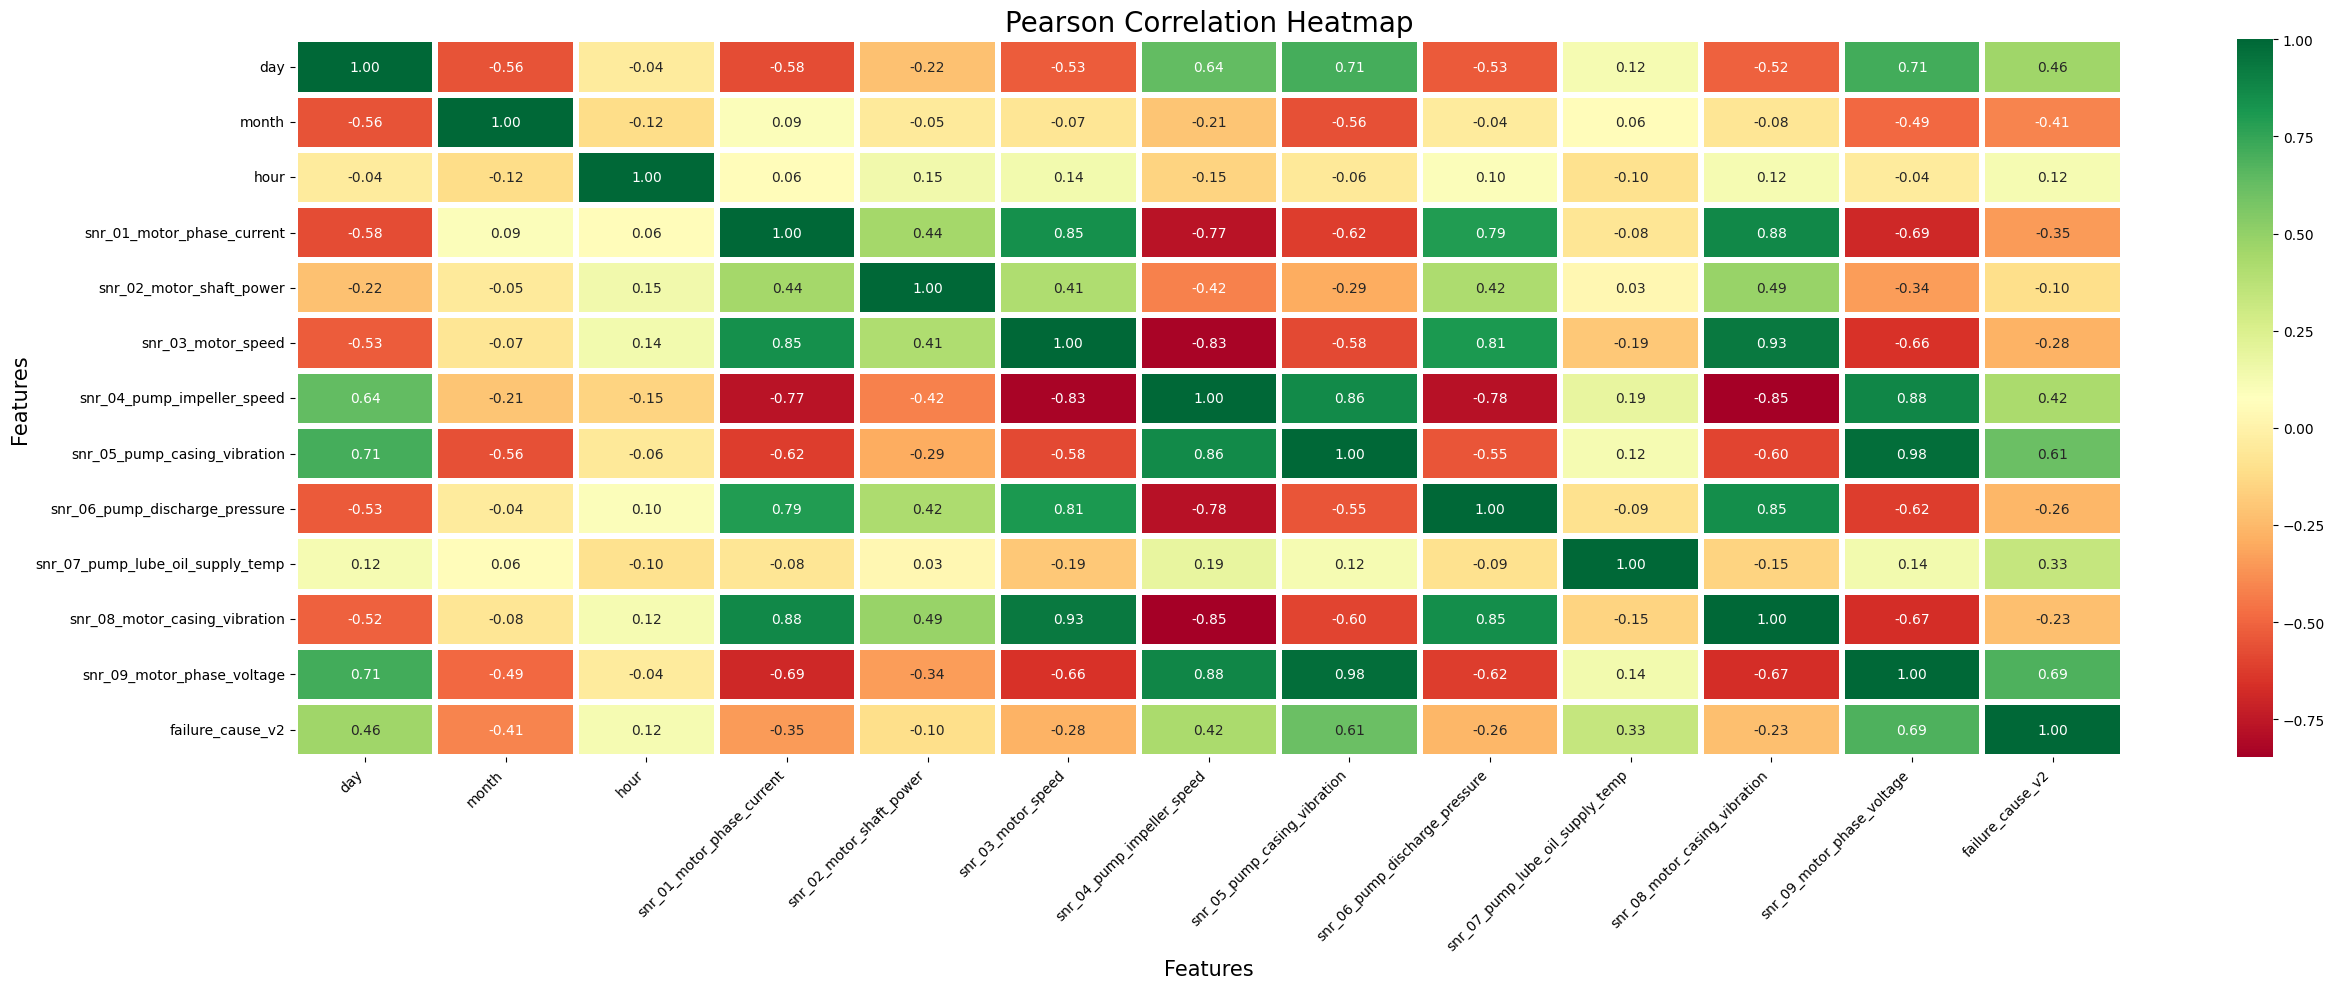

In [21]:
plt.figure(figsize=(26, 10))
sns.heatmap(corr, linewidths=4, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title('Pearson Correlation Heatmap', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Selecting the features**<a id='Selecting_the_features'></a>
[Contents](#Contents)

Now that we have our cleaned dataset, it's time to set up our features (X) and target variable (y) for modeling.




In [22]:
# let's define feature set (X) and target variable (y):
selected_features = ["day", "month", "hour",
     "snr_01_motor_phase_current", "snr_02_motor_shaft_power", "snr_03_motor_speed",
     "snr_04_pump_impeller_speed", "snr_05_pump_casing_vibration", "snr_06_pump_discharge_pressure",
     "snr_07_pump_lube_oil_supply_temp", "snr_08_motor_casing_vibration", "snr_09_motor_phase_voltage"]



X = df_failure[selected_features]

y = df_failure["failure_cause_v2"]

In [23]:
X.head()

,day,month,hour,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage
5447,28,4,13,11.1652,15.0535,617.3611,49.0317,1.7495,209.7801,30.2083,2.4388,383.9602
5448,28,4,13,11.1652,15.0535,617.3611,49.0317,1.7495,208.0440,30.2083,2.4388,383.9602
5449,28,4,13,10.9377,15.1186,623.8426,54.3729,1.7336,205.4398,30.2083,2.4369,382.7150
5450,28,4,13,10.8380,15.0535,639.4676,66.9203,1.7917,202.5463,30.2083,2.4349,389.8215
5451,28,4,13,10.8435,15.1186,624.5370,76.3643,1.7481,199.6528,29.9479,2.4388,383.7621


In [24]:
y.head()

,failure_cause_v2
5447,4
5448,4
5449,4
5450,4
5451,4


In [25]:
# Quick check:
print(X.shape, y.shape)

(21902, 12) (21902,)


In [26]:
print(y.value_counts(normalize=True) * 100)

failure_cause_v2
0   78.0203
1    7.9993
2    4.5932
3    3.9266
4    3.6115
5    1.8491
Name: proportion, dtype: float64


## **Splitting the Data for Training and Testing**<a id='Splitting_Data'></a>
[Contents](#Contents)

Now that we have our features (X) and target variable (y) set up, the next step is to split the data into training and testing sets.

Since this is time-series data, we need to be careful with how we split it. Instead of a random split, we'll preserve the order of time to avoid data leakage. We'll select a continuous chunk for training and another for testing to make the model more realistic.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.5,
                                                 random_state=1981,
                                                 stratify=y  # Ensures classes are balanced
)


# Check split sizes:
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (10951, 12) (10951,)
Testing set size: (10951, 12) (10951,)


## **Scaling the Features**<a id='Scaling_Features'></a>
[Contents](#Contents)

Since our dataset has different types of sensor readings (current, power, speed, pressure), their values vary widely. Some sensors might have values in the hundreds, while others are in decimals. This can make it harder for machine learning models to perform well.

To fix this, we'll standardize the data using StandardScaler, which transforms all features to have zero mean and unit variance.

In [28]:
# Initialize the scaler:
scaler = StandardScaler()

# Fit and transform the training data:
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler:
X_test_scaled = scaler.transform(X_test)

# Quick check on the scaled data:
print("Scaled training data shape:", X_train_scaled.shape)
print("Scaled testing data shape:", X_test_scaled.shape)


Scaled training data shape: (10951, 12)
Scaled testing data shape: (10951, 12)


## **Training Machine Learning Model**<a id='modeling'></a>
[Contents](#Contents)

With the data cleaned, split, and scaled, we're ready to train classification models to predict failure categories. We'll start with a popular model like Random Forest Classifier and then based on the result and time we can test other models.

In [29]:
model = RandomForestClassifier(n_estimators=100, random_state=223)

# Train the model:
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=223)

## **Model Evaluation**<a id='Model_Evaluation'></a>
[Contents](#Contents)

In [30]:
# Make predictions:
model_predictions = model.predict(X_test_scaled)

# Compute accuracy:
accuracy = accuracy_score(y_test, model_predictions)
print("\nModel Accuracy:", round(accuracy * 100, 2), "%")


Model Accuracy: 99.87 %


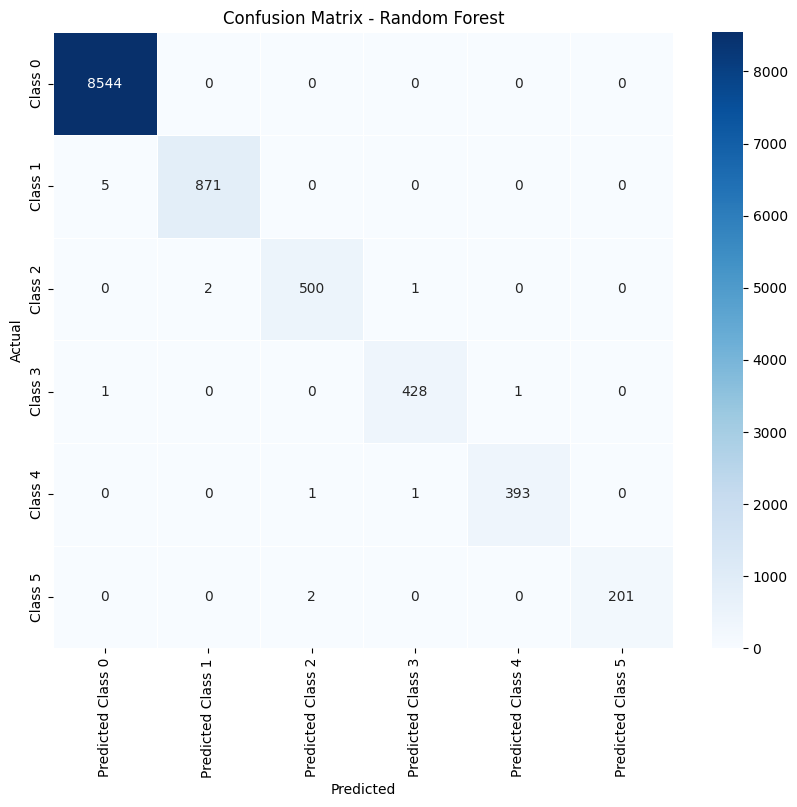

In [31]:
# Generate confusion matrix:
cm = confusion_matrix(y_test, model_predictions)

# Define class labels
class_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]

# Create a DataFrame for visualization
df_cm = pd.DataFrame(cm, index=class_labels, columns=[f"Predicted {label}" for label in class_labels])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

**Summary Highlights:**

* Model: we trained a Random Forest Classifier with 100 trees, keeping it stable with random_state=223.
* Accuracy: Solid 99.87%
* Confusion Matrix: Mostly spot-on predictions, but a few misclassifications here and there.


## **Features Importance**<a id='Features_Importance'></a>
[Contents](#Contents)

<ipython-input-32-bc8a200a10da>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="Blues_r")


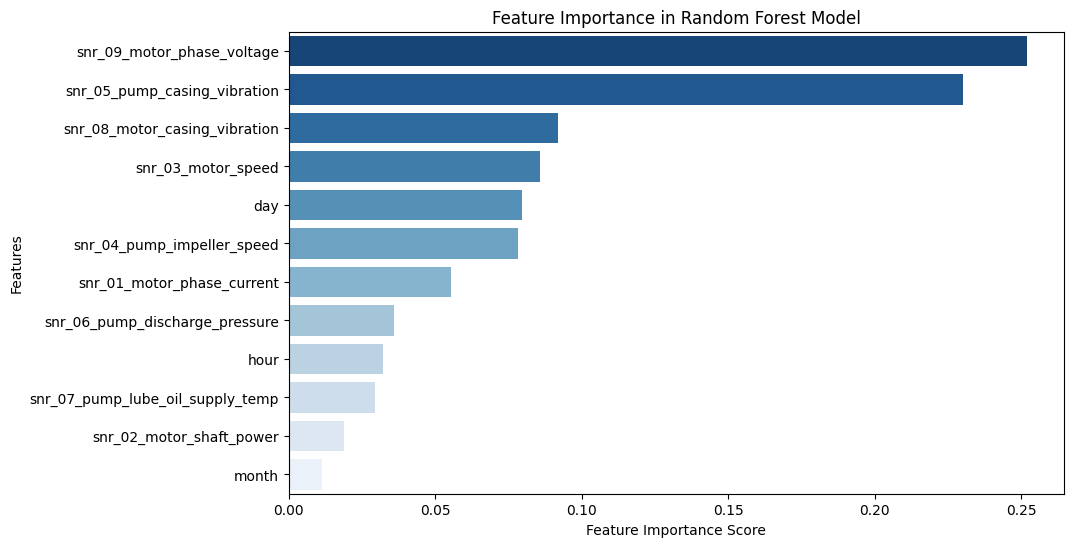

In [32]:
# Let's Extract feature importance from trained RandomForest model:
importances = model.feature_importances_

# Then, let's create a DataFrame to match feature names with importance values:
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})

# Sorting:
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance using Seaborn:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

In [33]:
# Ensure df_failure contains only the subset of df used for predictions:
df_failure = df.loc[X_test.index].copy()

# Store predicted labels:
df_failure["Predicted_Label"] = model_predictions

# Get predicted probabilities
probabilities = model.predict_proba(X_test)

# Convert probabilities into a DataFrame with proper column names:
prob_df = pd.DataFrame(probabilities,
                       columns=[f"Prob_Class_{i}" for i in range(probabilities.shape[1])],
                       index=X_test.index)  # Ensure index alignment

# Merge probability columns into df_failure
df_failure = df_failure.join(prob_df):

# Now, update the original dataset df with the new predictions and probabilities:
df.loc[df_failure.index, df_failure.columns] = df_failure

# Display first few rows to verify:
df.head()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,machine_status,snr_01_motor_phase_current_flag,snr_02_motor_shaft_power_flag,snr_03_motor_speed_flag,snr_04_pump_impeller_speed_flag,snr_05_pump_casing_vibration_flag,snr_06_pump_discharge_pressure_flag,snr_07_pump_lube_oil_supply_temp_flag,snr_08_motor_casing_vibration_flag,snr_09_motor_phase_voltage_flag,failure_category,failure_cause,faulty_sensors,Predicted_Label,Prob_Class_0,Prob_Class_1,Prob_Class_2,Prob_Class_3,Prob_Class_4,Prob_Class_5
0,2018-04-01 00:00:00,31.1172,15.0535,634.3750,665.3993,2.5653,201.3889,31.5104,2.4654,466.3284,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-01 00:01:00,31.1172,15.0535,634.3750,665.3993,2.5653,201.3889,31.5104,2.4654,466.3284,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-04-01 00:02:00,32.0889,15.0101,638.8889,666.2234,2.5001,203.7037,31.2500,2.4447,459.6364,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-04-01 00:03:00,31.6722,15.0825,628.1250,666.0114,2.5095,203.1250,31.5104,2.4605,460.8858,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-01 00:04:00,31.9520,15.0825,636.4583,663.2111,2.6048,201.3889,31.5104,2.4457,468.2206,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Saving the prediction dataset**<a id='Saving_prediction'></a>
[Contents](#Contents)

In [37]:
# Alright, let's save the DataFrame as a CSV file:
df.to_csv('/content/drive/My Drive/Colab Notebooks/failure_cause_predictions.csv', index=False)

In [38]:
# Here's, let's call our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,object,0,0.0000
snr_01_motor_phase_current,187145,float64,0,0.0000
snr_02_motor_shaft_power,566,float64,0,0.0000
snr_03_motor_speed,7845,float64,0,0.0000
snr_04_pump_impeller_speed,100422,float64,0,0.0000
snr_05_pump_casing_vibration,152604,float64,0,0.0000
snr_06_pump_discharge_pressure,1109,float64,0,0.0000
snr_07_pump_lube_oil_supply_temp,910,float64,0,0.0000
snr_08_motor_casing_vibration,1254,float64,0,0.0000
snr_09_motor_phase_voltage,148001,float64,0,0.0000
